In [8]:
import pyvoro
import random
import numpy as np
import time
from scipy.spatial import ConvexHull
import sys


In [34]:
def save_vertex(filev):
    vertex_list = []
    file = open(filev, "r")
    next(file)
    for line in file:
        l = line.split()
        if l[0] == '#':
            continue
        v = [float(l[1]), float(l[2]), float(l[3])]
        vertex_list.append(v)
    return np.array(vertex_list)

points = np.random.rand(994,3)
limits = [[0.0, 1.0], [0.0, 1.0], [0.0, 1.0]]

    # Se puede ajustar el tamaño del bloque según sea necesario
block_size = 0.1 # Este valor puede variar según tus necesidades

# Calcular el diagrama de Voronoi
t0 = time.time()
voronoi_result = pyvoro.compute_voronoi(points, limits, block_size)
print(len(points))
p = save_vertex("../data/Experiments/"+ str(1000) + 'random' +".1.node")
print(len(p))
voronoi_result = pyvoro.compute_voronoi(p, limits, block_size)
print(p)

994
994
missing cells: 0 1 6 7 9 11 19 20 21 22 23 28 31 33 37 48 54 58 64 65 67 70 73 76 91 92 97 102 104 108 113 119 122 124 127 136 145 148 150 154 155 160 166 169 173 174 179 181 183 196 200 201 204 205 208 210 223 227 230 241 248 250 254 266 268 280 289 294 298 309 313 318 320 322 330 338 339 342 343 350 355 358 359 360 361 362 364 365 367 368 372 383 390 399 400 402 403 405 406 409 421 426 430 431 439 441 443 448 450 452 462 467 471 472 473 475 477 478 482 485 488 489 490 494 495 499 513 516 518 520 523 524 528 532 535 536 541 542 544 551 557 565 570 571 572 574 578 579 583 585 586 590 594 596 603 605 610 611 613 614 617 620 625 626 628 631 637 639 640 641 643 646 652 659 666 667 668 674 675 676 678 681 689 690 695 697 704 706 708 710 711 712 714 717 724 732 736 744 746 748 751 753 754 758 763 766 768 771 773 775 779 781 782 783 788 789 790 791 792 793 794 798 803 807 815 817 821 824 831 836 840 841 843 844 846 852 855 857 864 865 866 867 869 873 874 879 884 890 896 901 905 906 9

VoronoiPlusPlusError: number of cells found was not equal to the number of particles.

In [29]:
def save_vertex(filev):
    vertex_list = []
    file = open(filev, "r")
    next(file)
    for line in file:
        l = line.split()
        if l[0] == '#':
            continue
        v = [float(l[1]), float(l[2]), float(l[3])]
        vertex_list.append(v)
    return np.array(vertex_list)

def generate_voronoi(numVertices, distribution):
    filename = "../data/Experiments/"+ str(numVertices) + distribution +".1.node"
    # points = np.random.rand(numVertices,3)
    points = save_vertex(filename)


# Ajustar los límites para el cubo de 1000x1000x1000
    limits = [[0.0, 1.0], [0.0, 1.0], [0.0, 1.0]]

    # Se puede ajustar el tamaño del bloque según sea necesario
    block_size = 0.1 # Este valor puede variar según tus necesidades

    # Calcular el diagrama de Voronoi
    t0 = time.time()
    voronoi_result = pyvoro.compute_voronoi(points, limits, block_size)
    tf = time.time()
    print('voronoi time = ', (tf-t0))
    vertexs = []
    polyhedrons = []
    minx = 0
    maxx = 0
    miny = 0
    maxy = 0
    minz = 0
    maxz = 0
    for cell in voronoi_result:
        vertexs+=cell['vertices']
        vertices = np.array(cell['vertices'])  # Convierte a array de NumPy para facilitar el manejo
        faces = cell['faces']
        cell_faces = []
        minx = min(minx,vertices[:, 0].min())
        miny = min(miny,vertices[:, 1].min())
        minz = min(minz,vertices[:, 2].min())

        maxx = max(maxx,vertices[:, 0].max())
        maxy = max(maxy,vertices[:, 1].max())
        maxz = max(maxz,vertices[:, 2].max())
        
        for face in faces:
            cell_faces.append(face['vertices'])

        polyhedrons.append([cell['vertices'],cell_faces, cell['volume']])

    # print(minx,maxx,miny,maxy,minz ,maxz)
    return polyhedrons

def generate_voronoi_poisson(radius):

    rng = np.random.default_rng()
    engine = qmc.PoissonDisk(d=3, radius=radius, seed=rng)
    points = engine.fill_space()

# Ajustar los límites para el cubo de 1000x1000x1000
    limits = [[0.0, 1.0], [0.0, 1.0], [0.0, 1.0]]

    # Se puede ajustar el tamaño del bloque según sea necesario
    block_size = 1.0 # Este valor puede variar según tus necesidades

    # Calcular el diagrama de Voronoi
    t0 = time.time()
    voronoi_result = pyvoro.compute_voronoi(points, limits, block_size)
    tf = time.time()
    dtV = (tf-t0)
    print('voronoi time = ', dtV)
    vertexs = []
    polyhedrons = []
    minx = 0
    maxx = 0
    miny = 0
    maxy = 0
    minz = 0
    maxz = 0
    for cell in voronoi_result:
        vertexs+=cell['vertices']
        vertices = np.array(cell['vertices'])  # Convierte a array de NumPy para facilitar el manejo
        faces = cell['faces']
        cell_faces = []
        minx = min(minx,vertices[:, 0].min())
        miny = min(miny,vertices[:, 1].min())
        minz = min(minz,vertices[:, 2].min())

        maxx = max(maxx,vertices[:, 0].max())
        maxy = max(maxy,vertices[:, 1].max())
        maxz = max(maxz,vertices[:, 2].max())
        
        for face in faces:
            cell_faces.append(face['vertices'])

        polyhedrons.append([cell['vertices'],cell_faces, cell['volume']])

    # print(minx,maxx,miny,maxy,minz ,maxz)
    return polyhedrons , dtV

In [11]:
from math import sqrt
from statistics import mean



def edges(polyhedron):
    edge_list=[]
    for face in polyhedron[1]:
        for i in range(len(face)):
            ei = [face[i%len(face)],face[(i+1)%len(face)]]
            ei.sort()
            if ei not in edge_list:
                edge_list.append(ei)

    return edge_list

def edges_length_ratio(polyhedron):
    length_list=[]
    for face in polyhedron[1]:
        for i in range(len(face)):
            ei = [face[i%len(face)],face[(i+1)%len(face)]]
            ei.sort()
            if ei not in length_list:
                v1 = polyhedron[0][ei[0]]
                v2 = polyhedron[0][ei[1]]
                l = sqrt(((v2[0]-v1[0])**2 + (v2[1]-v1[1])**2 + (v2[2]-v1[2])**2))
                length_list.append(l)

    shortest = min(length_list)
    longest = max(length_list)
    return shortest/longest

def n_faces(polyhedron):
    return len(polyhedron[1])

# area:
def face_area(face_vertex):
    area = [0,0,0]
    v0 = face_vertex[0]
    for i in range(1,len(face_vertex)-1):
        v1 = face_vertex[i]
        v2 = face_vertex[i+1]
        A = np.array([v1[0]-v0[0], v1[1]-v0[1], v1[2]-v0[2]])
        B = np.array([v2[0]-v0[0], v2[1]-v0[1], v2[2]-v0[2]])
        local_area = np.cross(A,B)
        area[0]+= local_area[0]
        area[1]+= local_area[1]
        area[2]+= local_area[2]
    return 0.5 * sqrt((area[0]**2 + area[1]**2) + area[2]**2)


def polyhedron_area_ratio(polyhedron):
    area = 0
    nodes = np.array(polyhedron[0])
    for face in polyhedron[1]:
        face_vertex = nodes[face]
        area += face_area(face_vertex)
    cvhull = ConvexHull(nodes)
    cvHull_area = cvhull.area
    ratio = area / cvHull_area
    return ratio

def is_convex(polyhedron):
    nodes = polyhedron[0]
    cvhull = ConvexHull(nodes)
    return set(cvhull.vertices) == set(range(len(nodes)))


# def write_polyhedron_file(filename,polyhedrons):
#     with open(filename+'.txt', 'w') as fh:
#         # polys = self.polyhedral_mesh
#         p = len(polyhedrons)
#         fh.write(str(p)+'\n')
#         c = 0
#         for polyhedron in polyhedrons:
#             list_face = polyhedron[1]
#             nodes = polyhedron[0]
#             # for tetra in polyhedron.tetras:
#             #     vertex = [self.mesh.tetra_list[tetra].v1, self.mesh.tetra_list[tetra].v2,self.mesh.tetra_list[tetra].v3,self.mesh.tetra_list[tetra].v4]
#             #     for v in vertex:
#             #         if v not in nodes :
#             #             nodes.append(v) 
#             fh.write("%d %d\n" % (len(nodes), len(list_face)))
#             for node in nodes:
#                 # v = self.mesh.node_list[node]
#                 fh.write("%f %f %f\n" % (node[0], node[1], node[2]))
#             nodes = np.array(polyhedron[0])
#             for f in list_face:
#                 # print(list_face)
#                 face_vertex = nodes[face]
#                 # t = self.mesh.face_list[f].neighs[0] if (self.mesh.face_list[f].neighs[0] in polyhedron.tetras) else self.mesh.face_list[f].neighs[1]
#                 if ccw_check(self.mesh.face_list[f], self.mesh.tetra_list[t],self.mesh.node_list):
#                     v1 = nodes.index(self.mesh.face_list[f].v1)
#                     v2 = nodes.index(self.mesh.face_list[f].v2)
#                     v3 = nodes.index(self.mesh.face_list[f].v3)
#                 else:
#                     v1 = nodes.index(self.mesh.face_list[f].v1)
#                     v2 = nodes.index(self.mesh.face_list[f].v3)
#                     v3 = nodes.index(self.mesh.face_list[f].v2)
#                 fh.write("3 %d %d %d # %d %d\n" % (v1, v2, v3,f,c))
#             c+=1


def analize_voronoi(numVertices,distribution):
    polyhedrons = generate_voronoi(numVertices,distribution)

    edge_ratios = []
    n_faces_list = []
    areas = []
    volumen = []
    convexs_polys = 0
    for polyhedron in polyhedrons:
        # print('vertices: ', polyhedron[0])
        # print('faces:', polyhedron[1])
        # print(edges(polyhedron))
        edge_ratio = edges_length_ratio(polyhedron)
        edge_ratios.append(edge_ratio)
        n_face = n_faces(polyhedron)
        n_faces_list.append(n_face)
        area = polyhedron_area_ratio(polyhedron)
        areas.append(area)
        volumen.append(polyhedron[2])
        if is_convex(polyhedron):
            convexs_polys+=1
    print('Cantidad de Poliedros; ', len(polyhedrons))
    print('Cantidad de Poliedros convexos; ', convexs_polys)
    print('Promedio Edge ratio: ', mean(edge_ratios))
    print('Minimum Edge ratio: ', min(edge_ratios))
    print('Maximum Edge ratio: ', max(edge_ratios))

    print('Promedio Numero de Caras: ', mean(n_faces_list))
    print('Minimum Numero de Caras: ', min(n_faces_list))
    print('Maximum Numero de Caras: ', max(n_faces_list))

    print('Promedio Area Ratio: ', mean(areas))
    print('Minimum Area Ratio: ', min(areas))
    print('Maximum Area Ratio: ', max(areas))

    print('Promedio Volume: ', mean(volumen))
    print('Minimum Volume: ', min(volumen))
    print('Maximum Volume: ', max(volumen))


In [30]:
analize_voronoi(1000,'random')


missing cells: 0 1 6 7 9 11 19 20 21 22 23 28 31 33 37 48 54 58 64 65 67 70 73 76 91 92 97 102 104 108 113 119 122 124 127 136 145 148 150 154 155 160 166 169 173 174 179 181 183 196 200 201 204 205 208 210 223 227 230 241 248 250 254 266 268 280 289 294 298 309 313 318 320 322 330 338 339 342 343 350 355 358 359 360 361 362 364 365 367 368 372 383 390 399 400 402 403 405 406 409 421 426 430 431 439 441 443 448 450 452 462 467 471 472 473 475 477 478 482 485 488 489 490 494 495 499 513 516 518 520 523 524 528 532 535 536 541 542 544 551 557 565 570 571 572 574 578 579 583 585 586 590 594 596 603 605 610 611 613 614 617 620 625 626 628 631 637 639 640 641 643 646 652 659 666 667 668 674 675 676 678 681 689 690 695 697 704 706 708 710 711 712 714 717 724 732 736 744 746 748 751 753 754 758 763 766 768 771 773 775 779 781 782 783 788 789 790 791 792 793 794 798 803 807 815 817 821 824 831 836 840 841 843 844 846 852 855 857 864 865 866 867 869 873 874 879 884 890 896 901 905 906 907 913 9

VoronoiPlusPlusError: number of cells found was not equal to the number of particles.

In [9]:
analize_voronoi(1000)

voronoi time =  0.20186400413513184
-2.7755575615628914e-17 1.0 -4.163336342344337e-17 1.0 -1.3877787807814457e-17 1.0
Cantidad de Poliedros;  1000
Cantidad de Poliedros convexos;  1000
Promedio Edge ratio:  0.02431230916246761
Minimum Edge ratio:  1.5856760275274876e-07
Maximum Edge ratio:  0.4371730420462092
Promedio Numero de Caras:  13.777
Minimum Numero de Caras:  5
Maximum Numero de Caras:  27
Promedio Area Ratio:  1.0
Minimum Area Ratio:  0.9999999999999991
Maximum Area Ratio:  1.0000000000000007
Promedio Volume:  0.001
Minimum Volume:  9.735959982582328e-05
Maximum Volume:  0.003192829438560447


In [10]:
analize_voronoi(10000)

voronoi time =  7.823276996612549
-1.3877787807814457e-17 1.0 -1.3877787807814457e-17 1.0 -1.3877787807814457e-17 1.0
Cantidad de Poliedros;  10000
Cantidad de Poliedros convexos;  10000
Promedio Edge ratio:  0.019221147004610615
Minimum Edge ratio:  8.645298542791992e-06
Maximum Edge ratio:  0.6390256498824958
Promedio Numero de Caras:  14.7443
Minimum Numero de Caras:  5
Maximum Numero de Caras:  29
Promedio Area Ratio:  1.0
Minimum Area Ratio:  0.999999999999999
Maximum Area Ratio:  1.0000000000000009
Promedio Volume:  9.999999999999999e-05
Minimum Volume:  9.463412421270387e-06
Maximum Volume:  0.00045320028667753545


In [4]:
analize_voronoi(50000)

voronoi time =  154.4006745815277
Cantidad de Poliedros;  50000
Cantidad de Poliedros convexos;  50000
Promedio Edge ratio:  0.0188165079199019
Minimum Edge ratio:  3.2684273422734994e-07
Maximum Edge ratio:  0.39936413264611487
Promedio Numero de Caras:  15.07698
Minimum Numero de Caras:  5
Maximum Numero de Caras:  32
Promedio Area Ratio:  1.0
Minimum Area Ratio:  0.9999999999999989
Maximum Area Ratio:  1.0000000000000013
Promedio Volume:  1.9999999999999998e-05
Minimum Volume:  9.896525979349288e-07
Maximum Volume:  9.179852751124151e-05


Number of points:  40008


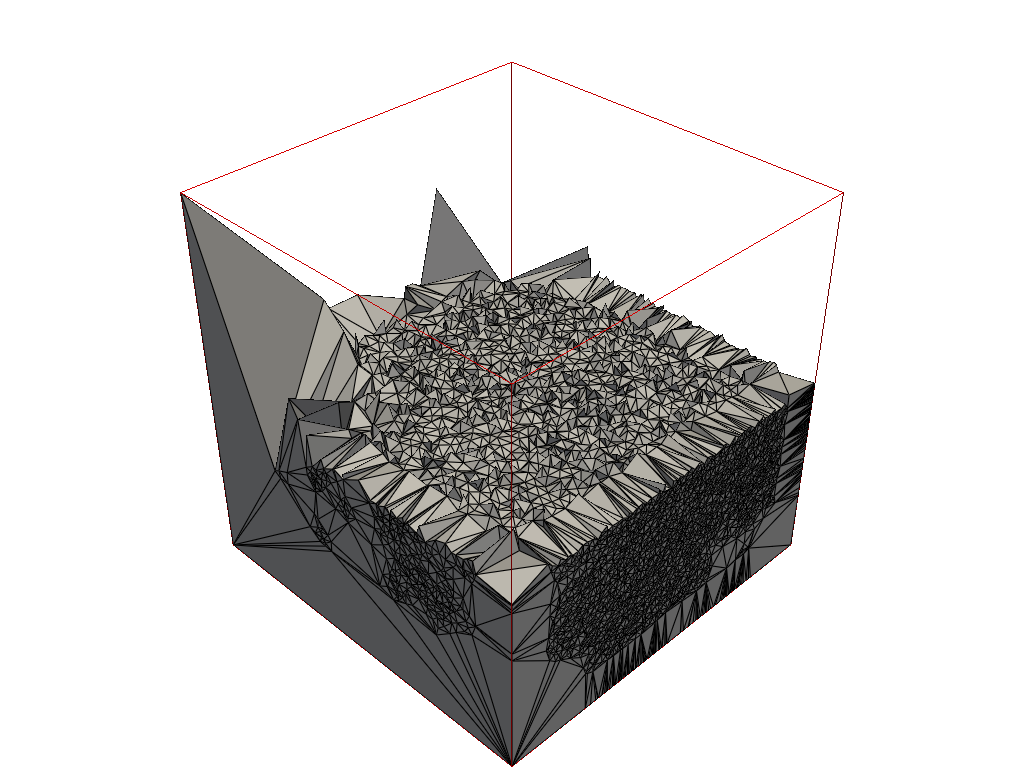

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import PatchCollection
import matplotlib.tri as tri
import pyvista as pv
import tetgen

# Random sampling and Poisson disk sampling
from scipy.stats import qmc
from scipy.spatial import Delaunay

def plot_pyvista(nodes, simplices):
    buf = np.empty((len(simplices), 1), pv.ID_TYPE)
    buf[:] = 4
    elements = np.hstack((buf, simplices))
    elements = elements.flatten()
    cell_type = np.empty(len(simplices), dtype='uint8')
    cell_type[:] = 10

    grid = pv.UnstructuredGrid(elements, cell_type, nodes)
    #grid = tgen.grid

    # get cell centroid
    
    #esta linea es maldita
    #cambia la dimension de los elementos de 1d a 2d n,5.
    # los copia al arreglo cells y le saca primera columna que corresponde al número de vértices
    cells = grid.cells.reshape(-1, 5)[:, 1:]
    #esta wea dado los indices de los vértices de cada celda,
    #obtiene las coordenadas de los vértices y calcula su promedio
    cell_center = grid.points[cells].mean(1)

    # extract cells below the 0 xy plane
    mask = cell_center[:, 2] < 0.5
    cell_ind = mask.nonzero()[0]
    subgrid = grid.extract_cells(cell_ind)
    # advanced plotting
    plotter = pv.Plotter(notebook=True)
    plotter.background_color = 'white'
    plotter.add_mesh(subgrid, 'lightgrey', lighting=True, show_edges=True)
    plotter.add_mesh(pv.Cube(center=(0.5, 0.5, 0.5)), 'r', 'wireframe')
    #plotter.add_legend([[' Input Mesh ', 'r'], [' Tessellated Mesh ', 'black']])
    plotter.show(jupyter_backend='static')

#Move a point to the boundary of the box if the distante to the boundary is less than tolerance
def move_point(max_number, xPoint , yPoint, zPoint, tolerance):
    r =  np.random.uniform(0, 1)
    n = max_number
    # A esta wea la faltan dos casos,pero no sé me ocurren como hacerlo ahora
    if r <= 0.5:
        #if the x coord is near the extreme x coord
        if xPoint >= max_number*(1.0-tolerance): 
            xPoint = n
        #if the y coord is near the extreme y coord
        if yPoint >= max_number*(1.0-tolerance): 
            yPoint = n
        #if the z coord is near the extreme z coord
        if zPoint >= max_number*(1.0-tolerance):
            zPoint = n
        #if the x coord is near the 0-x coord
        if xPoint <= max_number*tolerance: 
            xPoint = 0
        #if the y coord is near the 0-y coord
        if yPoint <= max_number*tolerance: 
            yPoint = 0
        #if the z coord is near the 0-z coord
        if zPoint <= max_number*tolerance:
            zPoint = 0
    else:
        #if the x coord is near the 0-x coord
        if xPoint <= max_number*tolerance: 
            xPoint = 0            
        #if the y coord is near the 0-y coord
        if yPoint <= max_number*tolerance: 
            yPoint = 0
        #if the z coord is near the 0-z coord  
        if zPoint <= max_number*tolerance:
            zPoint = 0
        #if the x coord is near the extreme x coord
        if xPoint >= max_number*(1.0-tolerance): 
            xPoint = n
        #if the y coord is near the extreme y coord
        if yPoint >= max_number*(1.0-tolerance): 
            yPoint = n
        #if the z coord is near the extreme z coord
        if zPoint >= max_number*(1.0-tolerance):
            zPoint = n
        

    #print("returning", xPoint, yPoint)
    return (xPoint, yPoint, zPoint)

def add_box(arr, tolerance):
    box = [[0, 0, 0], [0, 0, 1], [0, 1, 0], [0, 1, 1], [1, 0, 0], [1, 0, 1], [1, 1, 0], [1, 1, 1]]
    arr = np.append(arr, box, axis=0)
    np.unique(arr, axis=0)
    #maxNumber = max(max(arr[:,0]), max(arr[:,1]), max(arr[:,2]))
    for i in range(0, len(arr)):
        new_p = move_point(1, arr[i,0], arr[i,1], arr[i,2], tolerance)
        arr[i,0] = new_p[0]
        arr[i,1] = new_p[1]
        arr[i,2] = new_p[2]
    return arr

tolerance = 0.1
radius = 0.02 
rng = np.random.default_rng()
engine = qmc.PoissonDisk(d=3, radius=radius, seed=rng)
sample = engine.random(40000)

sample = add_box(sample, tolerance)
poissonTriangulation = Delaunay(sample)

poissonPoints = sample
poissonTriangles = poissonTriangulation.simplices.copy()

print("Number of points: ", len(poissonPoints))
plot_pyvista(poissonPoints, poissonTriangulation.simplices)